# Comparing US Treasury and ECB Yield Curve Methodologies (Draft)

This notebook compares:

- A US-style curve: bootstrapped discount factors and forwards from bond **prices**, with monotone-convex interpolation on forwards, then par yields.
- An ECB-style curve: Nelson–Siegel–Svensson (NSS) zero-coupon curve **fitted directly to market bond yields** implied by the same prices, then par yields.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

np.set_printoptions(precision=8, suppress=True)

## 1. Synthetic Input Data

In practice, you would pull the actual US **on‑the‑run set**; here we define a simple example.

In [2]:
# Synthetic on-the-run style input; replace with actual prices if desired
instruments = pd.DataFrame([
    {"maturity": 4/52, "type": "bill", "price": 99.10, "coupon": 0.0, "freq": 1},
    {"maturity": 13/52, "type": "bill", "price": 97.50, "coupon": 0.0, "freq": 1},
    {"maturity": 26/52, "type": "bill", "price": 95.00, "coupon": 0.0, "freq": 1},
    {"maturity": 2.0, "type": "bond", "price": 101.20, "coupon": 0.045, "freq": 2},
    {"maturity": 3.0, "type": "bond", "price": 102.00, "coupon": 0.041, "freq": 2},
    {"maturity": 5.0, "type": "bond", "price": 99.50, "coupon": 0.038, "freq": 2},
    {"maturity": 7.0, "type": "bond", "price": 98.20, "coupon": 0.038, "freq": 2},
    {"maturity": 10.0, "type": "bond", "price": 96.70, "coupon": 0.039, "freq": 2},
    {"maturity": 20.0, "type": "bond", "price": 95.00, "coupon": 0.041, "freq": 2},
    {"maturity": 30.0, "type": "bond", "price": 93.50, "coupon": 0.040, "freq": 2},
]).sort_values("maturity").reset_index(drop=True)

instruments

,maturity,type,price,coupon,freq
0,0.076923,bill,99.1,0.000,1
1,0.250000,bill,97.5,0.000,1
2,0.500000,bill,95.0,0.000,1
3,2.000000,bond,101.2,0.045,2
4,3.000000,bond,102.0,0.041,2
5,5.000000,bond,99.5,0.038,2
6,7.000000,bond,98.2,0.038,2
7,10.000000,bond,96.7,0.039,2
8,20.000000,bond,95.0,0.041,2
9,30.000000,bond,93.5,0.040,2


## 2. US-style: bootstrap discount factors and forwards

In [3]:
def _interp_log_df(t, mats, dfs):
    """Log-linear interpolation of discount factors between known maturities."""
    mats = np.asarray(mats)
    dfs = np.asarray(dfs)
    if t <= mats[0]:
        return dfs[0]
    if t >= mats[-1]:
        return dfs[-1]
    i = np.searchsorted(mats, t) - 1
    t0, t1 = mats[i], mats[i + 1]
    df0, df1 = dfs[i], dfs[i + 1]
    w = (t - t0) / (t1 - t0)
    log_df = np.log(df0) * (1 - w) + np.log(df1) * w
    return np.exp(log_df)


def bootstrap_discount_curve(instruments: pd.DataFrame):
    """
    Bootstrap discount factors from bill and coupon bond prices.

    Bills are treated as zero-coupon instruments. For coupon bonds, if an
    intermediate coupon date has no DF yet, interpolate log-DF.
    """
    inst = instruments.sort_values("maturity").reset_index(drop=True)
    maturities = []
    discounts = []

    for _, row in inst.iterrows():
        T = float(row["maturity"])
        P = float(row["price"]) / 100.0
        c = float(row["coupon"])
        freq = int(row["freq"])

        if row["type"] == "bill":
            df_T = P
            maturities.append(T)
            discounts.append(df_T)
        else:
            n = int(round(T * freq))
            cf_times = np.array([i / freq for i in range(1, n + 1)])
            coupon_cf = c / freq

            mats_arr = np.array(maturities)
            dfs_arr = np.array(discounts)

            pv_known = 0.0
            for t in cf_times[:-1]:
                if len(maturities) > 0:
                    df_t = _interp_log_df(t, mats_arr, dfs_arr)
                else:
                    raise ValueError("No discount factors available yet for interpolation.")
                pv_known += coupon_cf * df_t

            cf_T = 1.0 + coupon_cf
            df_T = (P - pv_known) / cf_T

            maturities.append(T)
            discounts.append(df_T)

    maturities = np.array(maturities)
    discounts = np.array(discounts)

    forwards = np.zeros(len(maturities) - 1)
    for i in range(len(forwards)):
        t0, t1 = maturities[i], maturities[i + 1]
        df0, df1 = discounts[i], discounts[i + 1]
        dt = t1 - t0
        forwards[i] = -np.log(df1 / df0) / dt

    return maturities, discounts, forwards


mats_us, dfs_us, F_intervals_us = bootstrap_discount_curve(instruments)
mats_us, dfs_us, F_intervals_us

(array([ 0.07692308,  0.25      ,  0.5       ,  2.        ,  3.        ,
         5.        ,  7.        , 10.        , 20.        , 30.        ]),
 array([0.991     , 0.975     , 0.95      , 0.92701711, 0.9054787 ,
        0.82183694, 0.7501709 , 0.64547773, 0.35874386, 0.27636229]),
 array([0.09404525, 0.10390195, 0.01632664, 0.02350828, 0.04846088,
        0.04562048, 0.05010345, 0.0587382 , 0.0260896 ]))

## 3. US-style: monotone-convex forward interpolation and par yields

In [4]:
def _node_forwards_from_interval(times, interval_forwards):
    times = np.asarray(times)
    F = np.asarray(interval_forwards)
    n = len(times)
    Fn = np.zeros(n)

    Fn[0] = F[0]
    Fn[-1] = F[-1]
    for i in range(1, n - 1):
        Fn[i] = 0.5 * (F[i - 1] + F[i])
    return Fn


def _hyman_filtered_slopes(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    h = np.diff(x)
    delta = np.diff(y) / h

    m = np.zeros_like(y)
    m[0] = delta[0]
    m[-1] = delta[-1]

    for i in range(1, n - 1):
        if delta[i - 1] * delta[i] > 0:
            w1 = 2 * h[i] + h[i - 1]
            w2 = h[i] + 2 * h[i - 1]
            m[i] = (w1 + w2) / (w1 / delta[i - 1] + w2 / delta[i])
        else:
            m[i] = 0.0

    for i in range(len(delta)):
        if delta[i] == 0:
            m[i] = 0
            m[i + 1] = 0
        else:
            a = m[i] / delta[i]
            b = m[i + 1] / delta[i]
            s = a * a + b * b
            if s > 9:
                tau = 3 / np.sqrt(s)
                m[i] = tau * a * delta[i]
                m[i + 1] = tau * b * delta[i]

    return m


def monotone_convex_forward(times, interval_forwards, eval_times):
    times = np.asarray(times)
    eval_times = np.asarray(eval_times)

    F_nodes = _node_forwards_from_interval(times, interval_forwards)
    m = _hyman_filtered_slopes(times, F_nodes)
    h = np.diff(times)

    f_eval = np.zeros_like(eval_times, dtype=float)

    for j, t in enumerate(eval_times):
        if t <= times[0]:
            i = 0
        elif t >= times[-1]:
            i = len(times) - 2
        else:
            i = np.searchsorted(times, t) - 1

        t0, t1 = times[i], times[i + 1]
        dt = h[i]
        x = (t - t0) / dt

        y0 = F_nodes[i]
        y1 = F_nodes[i + 1]
        m0 = m[i]
        m1 = m[i + 1]

        x2 = x * x
        x3 = x2 * x
        h00 = 2 * x3 - 3 * x2 + 1
        h10 = x3 - 2 * x2 + x
        h01 = -2 * x3 + 3 * x2
        h11 = x3 - x2

        f_eval[j] = (
            h00 * y0 +
            h10 * dt * m0 +
            h01 * y1 +
            h11 * dt * m1
        )

    return f_eval


def build_forward_function(times, interval_forwards):
    def f(t):
        t_arr = np.atleast_1d(t)
        res = monotone_convex_forward(times, interval_forwards, t_arr)
        return res[0] if np.isscalar(t) else res
    return f


f_us = build_forward_function(mats_us, F_intervals_us)


def discount_from_forward(f_func, t):
    if t == 0:
        return 1.0
    integral, _ = quad(f_func, 0.0, t, limit=20000)
    return np.exp(-integral)


def par_yield_from_forward(f_func, T, freq=2):
    n = int(round(T * freq))
    pay_times = np.array([i / freq for i in range(1, n + 1)])
    dfs = np.array([discount_from_forward(f_func, t) for t in pay_times])
    P_T = dfs[-1]
    c_annual = freq * (1.0 - P_T) / dfs.sum()
    return c_annual


target_tenors = np.array([0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])
par_us = {T: par_yield_from_forward(f_us, T, freq=2) for T in target_tenors}
par_us


C:\Users\offic\AppData\Local\Temp\ipykernel_28416\1333836339.py:107: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(f_func, 0.0, t, limit=20000)


{np.float64(0.5): np.float64(0.09023664853552202),
 np.float64(1.0): np.float64(0.06965715149949511),
 np.float64(2.0): np.float64(0.04814163755524438),
 np.float64(3.0): np.float64(0.04140838414642658),
 np.float64(5.0): np.float64(0.042095133324544),
 np.float64(7.0): np.float64(0.043619733984049815),
 np.float64(10.0): np.float64(0.045716697000663574),
 np.float64(20.0): np.float64(0.047618662628814756),
 np.float64(30.0): np.float64(0.04516036263098474)}

### 4. ECB-Style: compute “market” YTMs from input prices

In [5]:
def bond_price_from_yield(y, maturity, coupon, freq):
    """Price per 100 nominal for a bond with yield y.

    - If there are no coupon dates (m <= 0), treat as zero-coupon with payoff 100 at T.
    - Otherwise, standard fixed-coupon bond with freq coupons per year.
    """
    T = maturity
    c = coupon
    m = int(round(T * freq))

    if m <= 0:
        # Zero-coupon: one payment of 100 at T
        return float(100.0 / (1.0 + y * T))

    times = np.array([i / freq for i in range(1, m + 1)])
    cf = np.full_like(times, c / freq, dtype=float)
    cf[-1] += 1.0
    disc = (1 + y / freq) ** (-freq * times)
    return float(np.sum(cf * disc) * 100.0)

def solve_ytm(price, maturity, coupon, freq):
    """Solve yield-to-maturity from clean price using bisection."""
    P = price
    low, high = -0.05, 0.20  # allow slightly negative yields
    for _ in range(100):
        mid = 0.5 * (low + high)
        pmid = bond_price_from_yield(mid, maturity, coupon, freq)
        if pmid > P:
            low = mid
        else:
            high = mid
    return 0.5 * (low + high)


market_yields = []
for _, row in instruments.iterrows():
    T = float(row["maturity"])
    P = float(row["price"])
    c = float(row["coupon"])
    freq = int(row["freq"])

    if row["type"] == "bill":
        # Zero-coupon yield implied by discount price (simple annualized)
        y = (100.0 / P - 1.0) / T
    else:
        y = solve_ytm(P, T, c, freq)
    market_yields.append(y)

instruments_with_yield = instruments.copy()
instruments_with_yield["ytm"] = market_yields


## 5. ECB-style: NSS fit to market YTMs

In [6]:
def nss_zero_rate(T, beta0, beta1, beta2, beta3, tau1, tau2):
    T = np.asarray(T, dtype=float)
    T = np.maximum(T, 1e-6)
    x1 = T / tau1
    x2 = T / tau2

    term1 = (1 - np.exp(-x1)) / x1
    term2 = term1 - np.exp(-x1)
    term3 = (1 - np.exp(-x2)) / x2 - np.exp(-x2)

    z = beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3
    return z


def nss_discount_factor(T, beta0, beta1, beta2, beta3, tau1, tau2):
    z = nss_zero_rate(T, beta0, beta1, beta2, beta3, tau1, tau2)
    return np.exp(-z * T)

def nss_price_from_params(params, maturity, coupon, freq, inst_type):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    T = maturity
    c = coupon

    if inst_type == "bill":
        # Zero-coupon: single payment of 100 at T
        df_T = nss_discount_factor(T, beta0, beta1, beta2, beta3, tau1, tau2)
        return float(df_T * 100.0)

    # Coupon bond
    m = int(round(T * freq))
    if m <= 0:
        df_T = nss_discount_factor(T, beta0, beta1, beta2, beta3, tau1, tau2)
        return float(df_T * 100.0)

    times = np.array([i / freq for i in range(1, m + 1)])
    dfs = nss_discount_factor(times, beta0, beta1, beta2, beta3, tau1, tau2)
    cf = np.full_like(times, c / freq, dtype=float)
    cf[-1] += 1.0
    return float(np.sum(cf * dfs) * 100.0)

def nss_yield_from_params(params, maturity, coupon, freq, inst_type):
    P_model = nss_price_from_params(params, maturity, coupon, freq, inst_type)
    # For bills this will recover a yield consistent with the NSS discount factor;
    # for bonds it's a standard YTM.
    return solve_ytm(P_model, maturity, coupon, freq)

def nss_objective(params, instruments_df):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    if tau1 <= 0 or tau2 <= 0:
        return 1e9
    errs = []
    for _, row in instruments_df.iterrows():
        T = float(row["maturity"])
        c = float(row["coupon"])
        freq = int(row["freq"])
        inst_type = row["type"]
        y_obs = float(row["ytm"])

        y_model = nss_yield_from_params(params, T, c, freq, inst_type)
        errs.append(y_model - y_obs)

    errs = np.array(errs)
    if errs.size == 0:
        return 1e9
    return float(np.sum(errs**2))

x0 = np.array([0.04, -0.02, 0.02, 0.0, 1.5, 5.0])

res = minimize(
    nss_objective,
    x0,
    args=(instruments_with_yield,),
    method="Powell",               # instead of Nelder-Mead
    options={"maxiter": 5000, "disp": True}
)

params_nss = res.x
res


Optimization terminated successfully.
         Current function value: 0.000239
         Iterations: 17
         Function evaluations: 1125


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.00023920028097499377
       x: [ 8.526e-02  4.096e-02 -2.149e-01 -1.868e-01  1.535e+00
            5.777e+01]
     nit: 17
   direc: [[ 2.032e-03  3.537e-03 ... -2.761e-01  6.425e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-3.167e-05 -1.919e-04 ...  1.467e-02  9.396e+00]]
    nfev: 1125

## 6. ECB-style: par curve from fitted NSS

In [7]:
def nss_par_yield(T, params, freq=2):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    n = int(round(T * freq))
    pay_times = np.array([i / freq for i in range(1, n + 1)])
    dfs = nss_discount_factor(pay_times, beta0, beta1, beta2, beta3, tau1, tau2)
    P_T = dfs[-1]
    return freq * (1.0 - P_T) / dfs.sum()


def nss_par_curve(params, tenors, freq=2):
    return {T: nss_par_yield(T, params, freq=freq) for T in tenors}


par_ecb = nss_par_curve(params_nss, target_tenors, freq=2)
par_ecb


{np.float64(0.5): np.float64(0.09328381916870229),
 np.float64(1.0): np.float64(0.0694554447590847),
 np.float64(2.0): np.float64(0.044454169226677914),
 np.float64(3.0): np.float64(0.03560528980842055),
 np.float64(5.0): np.float64(0.03522401362854589),
 np.float64(7.0): np.float64(0.03953233054222648),
 np.float64(10.0): np.float64(0.04405759972414658),
 np.float64(20.0): np.float64(0.04595984123787867),
 np.float64(30.0): np.float64(0.04347685903658849)}

## 7. Comparison and plot

In [8]:
rows = []
for T in target_tenors:
    y_us = par_us.get(T, np.nan)
    y_ecb = par_ecb.get(T, np.nan)
    rows.append({
        "Maturity (Y)": T,
        "US par (MC forwards)": y_us,
        "ECB par (NSS, fit to YTM)": y_ecb,
        "Difference (US - ECB)": y_us - y_ecb
    })

comparison_df = pd.DataFrame(rows)
comparison_df


,Maturity (Y),US par (MC forwards),"ECB par (NSS, fit to YTM)",Difference (US - ECB)
0,0.5,0.090237,0.093284,-0.003047
1,1.0,0.069657,0.069455,0.000202
2,2.0,0.048142,0.044454,0.003687
3,3.0,0.041408,0.035605,0.005803
4,5.0,0.042095,0.035224,0.006871
5,7.0,0.043620,0.039532,0.004087
6,10.0,0.045717,0.044058,0.001659
7,20.0,0.047619,0.045960,0.001659
8,30.0,0.045160,0.043477,0.001684


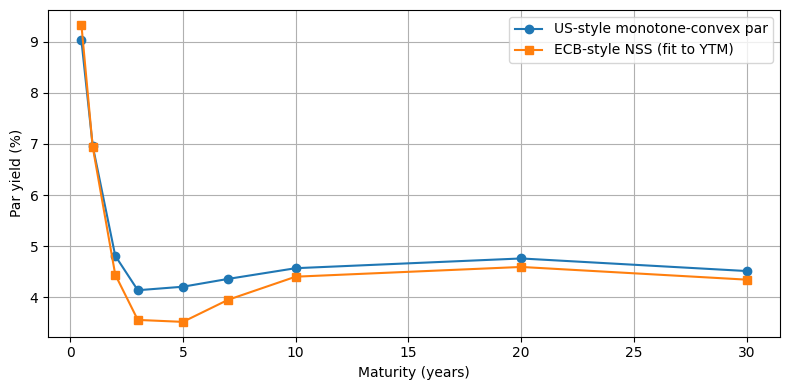

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(target_tenors, [par_us[T]*100 for T in target_tenors],
         marker="o", label="US-style monotone-convex par")
plt.plot(target_tenors, [par_ecb[T]*100 for T in target_tenors],
         marker="s", label="ECB-style NSS (fit to YTM)")
plt.xlabel("Maturity (years)")
plt.ylabel("Par yield (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***Suggested interpretation***: Once you align the data treatment (bills as zero‑coupon inputs in the NSS fit), the two methodologies give very similar par curves, especially beyond the very front end. The US‑style and ECB‑style par curves are very close everywhere, with only small, systematic differences.

- Short end (≤ 2–3 years)
Both curves now start at similar levels around 0.5y–1y; the orange NSS curve is slightly above the blue US curve at 0.5y, then drops a bit faster so that at 1–2y it lies marginally below the US curve.  Remaining differences (tens of bps at most) reflect global NSS smoothing vs. local monotone‑convex forwards.

- Belly and long end (5–30 years)
From 5y onward, US par is only a few basis points higher than NSS at most tenors and a very similar mild hump around 20y. Given this small synthetic cross‑section, both methods see essentially the same information in the intermediate and long maturities; the NSS global shape and the US forward spline produce nearly identical par levels, with NSS just marginally smoother and slightly lower on average.

The remaining differences are exactly what one would expect:
- US‑style: local, forward‑based monotone‑convex interpolation that prices each instrument exactly and preserves local shape.
- ECB‑style: global NSS zero‑curve fitted to all YTMs, emphasising smoothness and factor structure, with tiny deviations (a few bp) from the locally exact US spline.

## 8. Analysis
Both methods start from **bond prices**, but they target and fit different objects and impose different structure, which affects local fit, smoothness, and economic interpretation. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology)

### What is being fitted

- ECB: **Observed bond yields**  
  - Target: redemption yields (YTM) of many individual euro‑area government bonds across the curve. [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf)
  - The NSS curve is estimated by minimising the sum of squared differences between **model‑implied yields** (from the NSS discount function) and these observed yields. The NSS parameters determine the zero-coupon curve. [bis](https://www.bis.org/publ/bppdf/bispap25a.pdf)
  - The forward, and par curves are then derived from the zero-coupon curve. [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html)


- US Treasury: **Synthetic par curve directly**  
  - Inputs: indicative bid‑side prices (or discount rates for bills) of the on‑the‑run Treasury set. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/yield-curve-methodology-change-information-sheet)
  - They bootstrap **instantaneous forward rates** so that these specific securities are priced without error, then apply monotone‑convex interpolation on forwards and read off the **par yield curve**. [actuarial](https://www.actuarial.news/2022/09/21/daily-treasury-par-yield-curve-rates-2/)
  - The official published object is already a par curve at standard maturities (CMTs). [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology)

### Cross‑section vs. curve type

- ECB: cross‑section of yields on many bonds  
  - Uses a **broad universe** (dozens or hundreds of bonds) spanning 3M–30Y, both coupon and zero‑coupon/STRIPS. [data.ecb.europa](https://data.ecb.europa.eu/methodology/yield-curves)
  - Each bond’s price is matched approximately (least squares), giving a curve that reflects the **average pricing** of that whole market segment.  
  - This is a **zero‑coupon (spot)** curve by construction; par rates are secondary outputs. [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf)


- US Treasury: small set of on‑the‑run instruments  
  - Uses only **most recently auctioned** bills, notes and bonds at specific maturities; off‑the‑run paper is not used. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/yield-curve-methodology-change-information-sheet)
  - These instruments are matched essentially **exactly**, then the par curve is interpolated between them.  
  - The resulting curve is **par** by design; the zero‑coupon curve is implicit via forwards. [diversification](https://diversification.com/term/zero-coupon-yield-curve)

### Model structure and flexibility

- ECB NSS (parametric):  
  - Six parameters \((\beta_0,\dots,\tau_2)\) constrain the shape: level, slope and two curvature “humps”. [bis](https://www.bis.org/publ/bppdf/bispap25a.pdf)
  - Advantages: smooth, stable over time, easy factor interpretation; but **cannot exactly match all local kinks** in market data.  
  - Fitting directly to observed YTMs avoids dependence on any prior spot/par model, but the functional form is restrictive.


- US monotone‑convex (spline on forwards):  
  - Highly **local**, shape‑preserving interpolation of bootstrapped forwards. [home.treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/treasury-yield-curve-methodology)
  - Advantages: exact pricing for inputs, preserves monotonicity/convexity in forwards, flexible around input maturities.  
  - Drawback: depends heavily on the chosen input set (on‑the‑run only) and may capture micro‑structure noise more than a smooth parametric fit.

### Practical consequences

- Short / liquid tenors:  
  - Both curves are tightly constrained by deep markets; differences will be small and reflect mainly modelling choices (NSS global smoothness vs forward‑spline local fit). [ecb.europa](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html)
- Intermediate / long tenors and gaps:  
  - ECB: NSS effectively **smooths across gaps** and noisy bonds, giving a macro‑oriented “average” term structure (useful for term premia, macro modelling, cross‑country comparisons). [ecb.europa](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf)
  - US: the monotone‑convex curve **honours the on‑the‑run points exactly**, which is ideal for pricing/hedging around those securities, but long‑tenor behaviour between them is driven by the interpolation scheme rather than a global factor structure. [bis](https://www.bis.org/publ/bppdf/bispap25.htm)
- Dependence on synthetic yields:  
  - ECB: baseline fit is to **actual bond yields**; synthetic par/zero series are outputs, not inputs. [data.ecb.europa](https://data.ecb.europa.eu/methodology/yield-curves)
  - US: official output is par; the underlying zero/forward structure is inferred (and not directly published), but still rooted in actual prices of the on‑the‑run securities. [actuarial](https://www.actuarial.news/2022/09/21/daily-treasury-par-yield-curve-rates-2/)

In this notebook, we mimic ECB by fitting NSS to synthetic par yields from the US curve; the **real** ECB process instead fits NSS straight to market bond yields, which makes it less dependent on another model’s structure but more constrained by the cross‑section of actual traded instruments.